In [1]:
from dataclasses import dataclass
import pandas as pd
import numpy as np
import random
from decimal import Decimal
import heapq
import time
import matplotlib.pyplot as plt 
import matplotlib
from Objectcopy import ConvertibleBondObject, AccountData
import quantstats as qs
qs.extend_pandas()

In [2]:
import os
os.chdir('../')

In [3]:
matplotlib.rcParams['font.sans-serif'] = ['Times New Roman'] 

#### 1.数据导入

In [4]:
redemption = pd.read_excel("./Data/强制赎回统计.xlsx") 
redemption.loc[:,"OUT_STATUS"] = True
redemption_pivot = redemption.pivot(index = "ANN_DATE",columns = "S_INFO_WINDCODE",values = "OUT_STATUS")#long2wide format 
redemption_pivot.index = pd.to_datetime(redemption_pivot.index)
redemption_pivot

S_INFO_WINDCODE,110032.SH,110033.SH,110035.SH,110039.SH,110040.SH,110041.SH,110042.SH,110046.SH,110049.SH,110050.SH,...,128103.SZ,128104.SZ,128107.SZ,128110.SZ,128112.SZ,128113.SZ,128115.SZ,128126.SZ,128139.SZ,128145.SZ
ANN_DATE,,,,,,,,,,,,,,,,,,,,,
2017-05-23,NaN,NaN,True,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2017-05-24,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2017-07-18,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-06-12,NaN,NaN,NaN,True,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-07-16,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-04-12,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2023-04-20,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2023-04-27,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [5]:
close_price = pd.read_excel("./Data/收盘价.xlsx",index_col = 0)
open_price = pd.read_excel("./Data/开盘价.xlsx",index_col = 0)
avg_price = pd.read_excel("./Data/均价.xlsx",index_col = 0)

In [6]:
rankings = pd.read_excel("./Data/债项评级.xlsx",index_col = 0)
outstanding_balance = pd.read_excel("./Data/债券余额.xlsx",index_col = 0)
important_date = pd.read_excel("./Data/重要日期.xlsx",index_col = 0)#各债券发行及退市日期，转股期长度6/5年
premium = pd.read_excel("./Data/转股溢价率.xlsx",index_col = 0)

#### 2.数据清洗

In [7]:
important_date.SETUP_DATE = pd.to_datetime(important_date.SETUP_DATE)
important_date.DELIST_DATE = pd.to_datetime(important_date.DELIST_DATE)#债券发行及退市时间

In [8]:
for i in important_date.index:
    mature_date = f"{important_date.at[i,'SETUP_DATE'].year + important_date.at[i,'SETUP_TERM']}-{important_date.at[i,'SETUP_DATE'].month}-{important_date.at[i,'SETUP_DATE'].day}"
    important_date.loc[i,"MATURE_DATE"] = mature_date
    
important_date.MATURE_DATE = pd.to_datetime(important_date.MATURE_DATE)

In [9]:
filled_close_price = close_price.asfreq("D").ffill()
filled_open_price = open_price.asfreq("D").ffill()
filled_avg_price = avg_price.asfreq("D").ffill()
filled_rankings = rankings.asfreq("D").ffill()
filled_outstanding_balance = outstanding_balance.asfreq("D").ffill()
filled_premium = premium.asfreq("D").ffill()

In [10]:
# 剔除上市之前和最后一个交易日后的市场数据
for cb in important_date.index:
    setup_date = important_date.at[cb,"SETUP_DATE"]
    delist_date = important_date.at[cb,"DELIST_DATE"]
    for df in [filled_close_price,filled_open_price,filled_avg_price,filled_rankings,filled_outstanding_balance,filled_premium]:
        df.loc[:setup_date-pd.Timedelta(days = 1),cb] = np.nan
        df.loc[delist_date+pd.Timedelta(days = 1):,cb] = np.nan

#### 3.计算双低值

In [11]:
double_low_info1 =  filled_premium #(低溢价率)
double_low_info2 = filled_close_price #(低转债价格)
double_low_info3 = filled_close_price + filled_premium#双低值=转债现价+（转股溢价率×100）
print(double_low_info3)

            110038.SH  110043.SH  110044.SH  110045.SH  110047.SH  110048.SH   
2016-12-30        NaN        NaN        NaN        NaN        NaN        NaN  \
2016-12-31        NaN        NaN        NaN        NaN        NaN        NaN   
2017-01-01        NaN        NaN        NaN        NaN        NaN        NaN   
2017-01-02        NaN        NaN        NaN        NaN        NaN        NaN   
2017-01-03        NaN        NaN        NaN        NaN        NaN        NaN   
...               ...        ...        ...        ...        ...        ...   
2023-05-05   134.7047   126.4332   303.3626   136.1165   135.3413   201.0589   
2023-05-06   134.7047   126.4332   303.3626   136.1165   135.3413   201.0589   
2023-05-07   134.7047   126.4332   303.3626   136.1165   135.3413   201.0589   
2023-05-08   134.7047   128.4187   297.6996   137.7242   134.6378   203.9264   
2023-05-09   134.7047   126.7694   300.7682   137.9288   132.5745   200.0436   

            110052.SH  110053.SH  11005

#### 4.获取剩余期限

In [12]:
begin_date = pd.to_datetime(filled_close_price.index[2])
end_date = pd.to_datetime(filled_close_price.index[-1])
backtest_date_range = pd.date_range(begin_date,end_date)#获取交易日期范围 2017-01-01/2023-05-09

In [13]:
# 获取剩余期限
mature_date_info = pd.DataFrame(index = backtest_date_range,columns = filled_close_price.columns)

for i in mature_date_info.index:
    for j in mature_date_info.columns:
        if i >= important_date.at[j,"SETUP_DATE"] and i <= important_date.at[j,"MATURE_DATE"]:#如果当前交易日期大于发行日且小于到期日
            mature_date_info.at[i,j] = (important_date.at[j,"MATURE_DATE"] - i).days


#### 5.获取回测结果

In [14]:
'''paramaters'''
position_size:int = 10 
outstanding_balance_threshold:float = 3.0 
ranking_selected:list = ["AA-","AA","AA+","AAA-","AAA"]
maturity_threshold:int = 365
rotation_days = 30 #轮动时间 
'''variables'''
capital:float = 3000000.0
backtest_position:pd.DataFrame = pd.DataFrame(index = backtest_date_range,columns = ["CB_CODE"])
backtest_pnl_result:pd.DataFrame = pd.DataFrame(index = backtest_date_range,columns = ["NET_VALUE","PNL_RATIO_DAILY"])

In [15]:
backtest_account = AccountData(capital) # initial personal account

In [16]:
#backtesting
for ix,date in enumerate(backtest_date_range):
    """"""
    print_positions = False
    try:
        next_date = backtest_date_range[ix + 1]
    
    except IndexError:
        next_date = date + pd.Timedelta(days = 1)
    
    # 交易日当天发布赎回的转债先加入delete_cb里面
    backtest_account.delete_cb.extend(redemption.query("ANN_DATE == '{}'".format(date)).S_INFO_WINDCODE.tolist())
    
    # 清除触发赎回条款的转债
    for to_redemption_cb in list(backtest_account.in_position_cb.keys()):
        try:
            if redemption_pivot.at[date,to_redemption_cb] == True:
                backtest_account.in_position_cb[to_redemption_cb].calculate_daily_result_bond(
                    price = float(Decimal(filled_close_price.at[date,to_redemption_cb]).quantize(Decimal('0.0000'))),
                    date = date)

                backtest_account.sell(
                    vt_symbol = to_redemption_cb,
                    sell_price = float(Decimal(backtest_account.in_position_cb[to_redemption_cb].price).quantize(Decimal('0.0000'))),####sell_price会用之前调用calculate_daily_result_bond的price
                    volume = backtest_account.in_position_cb[to_redemption_cb].volume,
                    status = 'dsell',
                )
                print(f"sell {to_redemption_cb} at {backtest_account.in_position_cb[to_redemption_cb].price} in {date}, pnl is {backtest_account.in_position_cb[to_redemption_cb].pnl_ratio_total}")
        except (KeyError , IndexError):
            pass

    
    if ix % rotation_days == 0:
        # 自定义pool
        in_pool_cb = double_low_info3.loc[date,#(filled_outstanding_balance.loc[date] > outstanding_balance_threshold) & \
                                         #(outstanding_balance_threshold1>filled_outstanding_balance.loc[date] ) & \
                                         #(filled_rankings.loc[date].isin(["AA","AA+","AAA-","AAA"])) & \
                                         #(mature_date_info.loc[date] >= 365)].dropna().sort_values().index.tolist()
                                         (mature_date_info.loc[date] >= maturity_threshold)].dropna().sort_values().index.tolist()
        for i in set(backtest_account.delete_cb) & set(in_pool_cb):
            in_pool_cb.remove(i)
        in_pool_cb = in_pool_cb[:position_size]

        # 未进入pool的债券清仓
        backtest_account.clear_positions(date=date,in_pool_cb=in_pool_cb,filled_close_price=filled_close_price)
        print("Account positions after selling:")
        backtest_account.print_position(date)
        print_positions = True
        
        double_low_values = double_low_info3.loc[date, in_pool_cb].to_dict()
        in_pool_cb.sort(key=lambda cb: double_low_values.get(cb, float('inf')))
        to_position_cbs = sorted(set(in_pool_cb) - set(backtest_account.in_position_cb.keys()))
        num_to_position_cbs = len(set(in_pool_cb) - set(backtest_account.in_position_cb.keys()))
        print(num_to_position_cbs)
        backtest_account.buy_positions(date=date,to_position_cbs=to_position_cbs,filled_open_price=filled_open_price,num_to_position_cbs=num_to_position_cbs)
        
        time.sleep(0.01)
        print("Account positions after buying:")
        backtest_account.print_position(date)
        print_positions = True
        ''''''

    if ix % rotation_days != 0:
       for vt_symbol in backtest_account.in_position_cb.keys():
            backtest_account.in_position_cb[vt_symbol].calculate_daily_result_bond(
                price = float(Decimal(filled_close_price.at[date,vt_symbol]).quantize(Decimal('0.0000'))),
                date=date#加了date
            )
    if not print_positions:
        print("Account positions:")
        backtest_account.print_position(date)


        # update account info
    backtest_account.calculate_daily_result()
    backtest_account.remove_sold_order()
    backtest_pnl_result.loc[date,["NET_VALUE","PNL_RATIO_DAILY"]] = backtest_account.balance,backtest_account.pnl_ratio_daily


Account positions after selling:
10
2700465.4647
finished
buy  110032.SH at 109.61 in 2017-01-01 00:00:00,volume=2730.0
2401164.8630999997
finished
buy  110033.SH at 114.56 in 2017-01-01 00:00:00,volume=2610.0
2102210.2070999998
finished
buy  110034.SH at 122.4 in 2017-01-01 00:00:00,volume=2440.0
1803143.7393999998
finished
buy  110035.SH at 123.97 in 2017-01-01 00:00:00,volume=2410.0
1503822.7174
finished
buy  113009.SH at 115.9 in 2017-01-01 00:00:00,volume=2580.0
1204870.2636
finished
buy  113010.SH at 113.99 in 2017-01-01 00:00:00,volume=2620.0
905303.2959
finished
buy  127003.SZ at 113.79 in 2017-01-01 00:00:00,volume=2630.0
605845.5773400001
finished
buy  128009.SZ at 120.144 in 2017-01-01 00:00:00,volume=2490.0
306969.84018000006
finished
buy  128010.SZ at 118.483 in 2017-01-01 00:00:00,volume=2520.0
7374.544180000084
finished
buy  128011.SZ at 127.36 in 2017-01-01 00:00:00,volume=2350.0
Account positions after buying:
  110032.SH: buy_price=109.61, volume=2730.0,buy_date=2017-

In [17]:
print(backtest_pnl_result.NET_VALUE)

2017-01-01        3000000.0
2017-01-02       3012601.65
2017-01-03        3023742.8
2017-01-04       3060248.91
2017-01-05       3056052.47
                  ...      
2023-05-05    4902121.26607
2023-05-06    4902121.26607
2023-05-07    4902121.26607
2023-05-08    4979610.36607
2023-05-09    4898235.70607
Freq: D, Name: NET_VALUE, Length: 2320, dtype: object


In [18]:
close_zzzz = pd.read_excel("Data/中证转债收盘价.xlsx",index_col = 0)
close_zzzz = pd.Series(close_zzzz['close'], index=pd.to_datetime(close_zzzz.index))
close_zzzz = close_zzzz.resample('D').ffill()
close_zzzz = close_zzzz.iloc[2:]
print(close_zzzz)

2017-01-01    283.3437
2017-01-02    283.3437
2017-01-03    284.1168
2017-01-04    285.8681
2017-01-05    286.0264
                ...   
2023-05-05    406.6624
2023-05-06    406.6624
2023-05-07    406.6624
2023-05-08    409.4431
2023-05-09    407.5744
Freq: D, Name: close, Length: 2320, dtype: float64


In [28]:
with pd.ExcelWriter('output.xlsx') as writer:
    backtest_pnl_result.NET_VALUE.to_excel(writer, sheet_name='MySheet1')

with pd.ExcelWriter('output.xlsx', mode='a') as writer:  # 使用mode='a'来追加到同一个Excel文件中
    close_zzzz.to_excel(writer, sheet_name='MySheet2')


In [20]:
# 存储要计算的年份
years = ['2017', '2018', '2019', '2020','2021','2022','2023']

for year in years:
    # 提取对应年份的收益数据
    returns_series = backtest_pnl_result.NET_VALUE[f'{year}/1/1':f'{year}/12/31']
    # 计算年化收益率
    annual_return = qs.stats.cagr(returns_series)
    print(f"Annual Return {year}: {annual_return}")
    zzzz = close_zzzz[f'{year}/1/1':f'{year}/12/31']
    # zzzz年化收益率
    annual_return = qs.stats.cagr(zzzz)
    print(f"zzzz_Annual Return {year}: {annual_return}")
    # 计算年化波动率
    annual_volatility = qs.stats.volatility(returns_series, annualize=True)
    print(f"Annual Volatility {year}: {annual_volatility}")
    # 计算夏普比率
    sharpe_ratio = qs.stats.sharpe(returns_series)
    print(f"Sharpe Ratio {year}: {sharpe_ratio}")
    # 计算最大回撤
    max_drawdown = qs.stats.max_drawdown(returns_series)
    print(f"Max Drawdown {year}: {max_drawdown}")
    # zzzz最大回撤
    zzzz_max_drawdown = qs.stats.max_drawdown(zzzz)
    print(f"zzzz_Max Drawdown{year}: {zzzz_max_drawdown}")
    # 计算Calmar比率
    calmar = qs.stats.calmar(returns_series)
    print(f"Calmar {year}: {calmar}")
    # 计算胜率
    win_rate = qs.stats.win_rate(returns_series)
    print(f"Win rate {year}: {win_rate}")
    # 计算盈亏比
    profit_ratio = qs.stats.profit_factor(returns_series)
    print(f"Profit ratio {year}: {profit_ratio}")
    #信息比率
    returns_series = returns_series.pct_change().dropna()#改成收益率序列
    close_zzzz_returns = zzzz.pct_change().dropna()
    information_ratio = qs.stats.information_ratio(returns=returns_series, benchmark=zzzz)
    print(f"Information Ratio: {information_ratio}")

Annual Return 2017: -0.023647964494874385
zzzz_Annual Return 2017: -0.0016226180179597094
Annual Volatility 2017: 0.07565818692152938
Sharpe Ratio 2017: -0.180076923938431
Max Drawdown 2017: -0.12530121756751889
zzzz_Max Drawdown2017: -0.10258318764132979
Calmar 2017: -0.18872892820958884
Win rate 2017: 0.4738955823293173
Profit ratio 2017: 0.9647541012499796
Information Ratio: 0.051829202969070044
Annual Return 2018: -0.06825931977270727
zzzz_Annual Return 2018: -0.011640301404866382
Annual Volatility 2018: 0.08914575326421191
Sharpe Ratio 2018: -0.5013535525908936
Max Drawdown 2018: -0.157156200952683
zzzz_Max Drawdown2018: -0.12117586312880424
Calmar 2018: -0.43434060736336677
Win rate 2018: 0.4523809523809524
Profit ratio 2018: 0.8982665316787715
Information Ratio: 0.04779455020021464
Annual Return 2019: 0.4145116993065574
zzzz_Annual Return 2019: 0.25224671255072106
Annual Volatility 2019: 0.13622607858930444
Sharpe Ratio 2019: 1.8214465955817247
Max Drawdown 2019: -0.136678402441

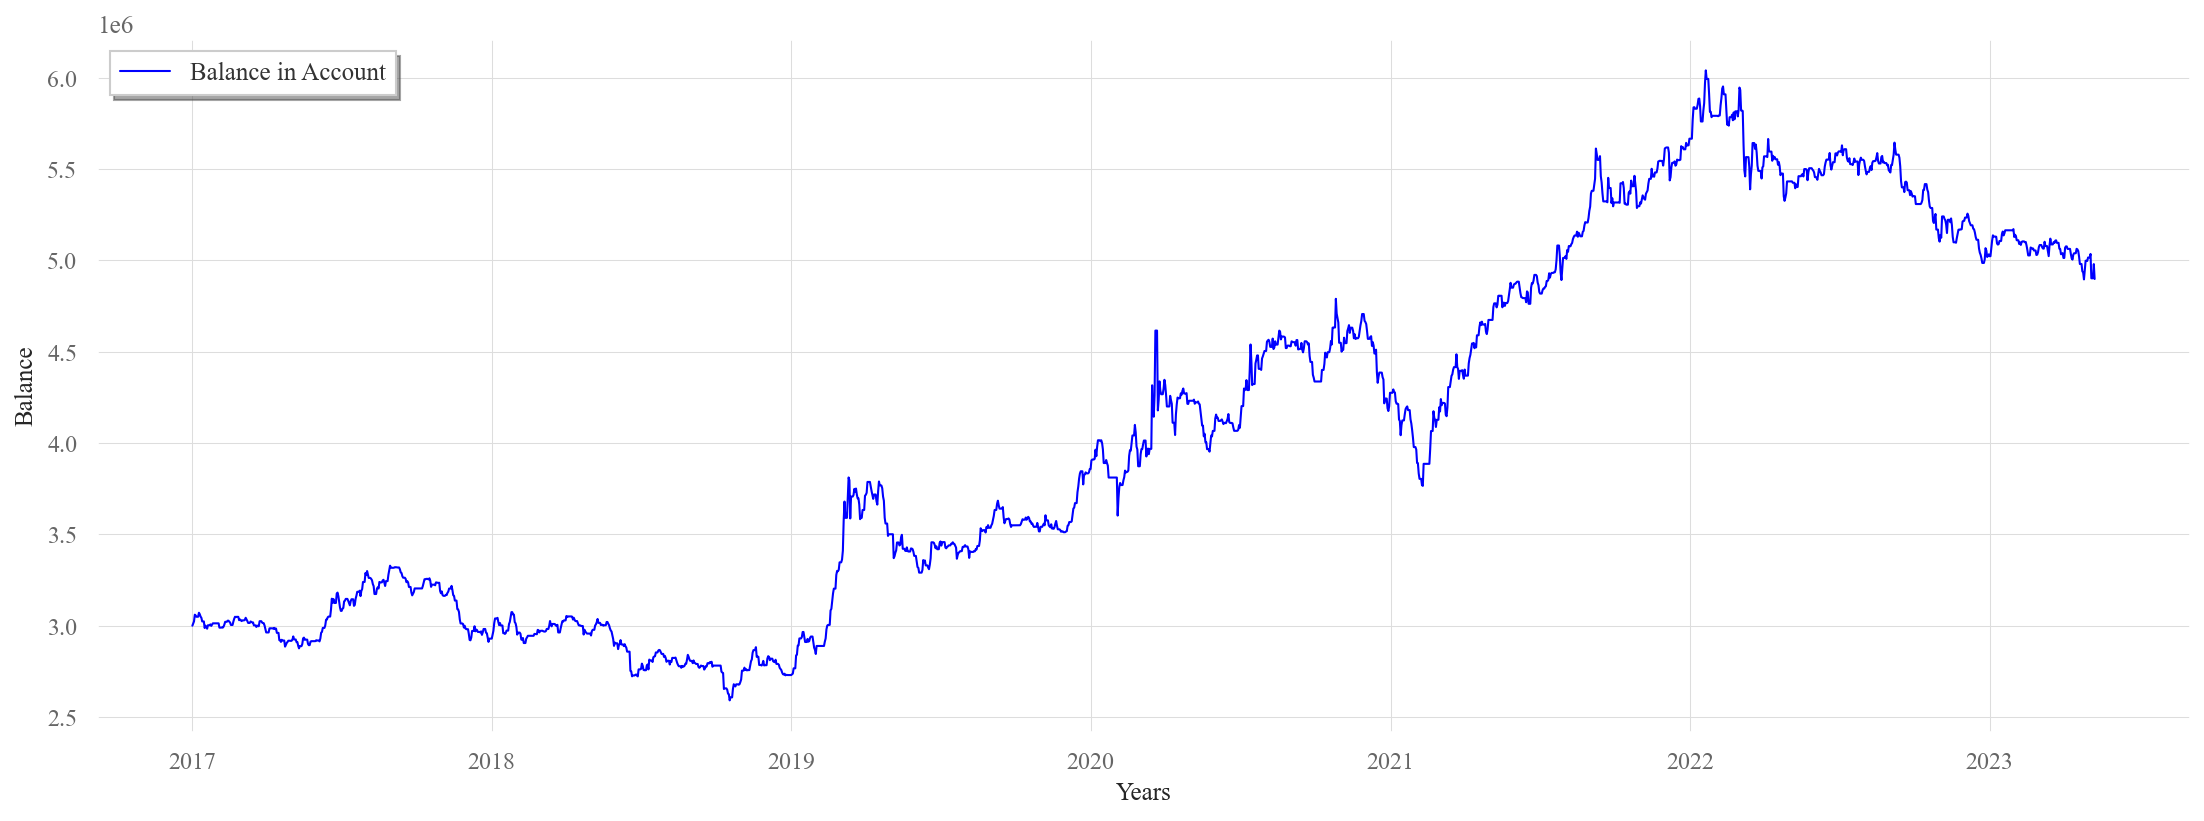

In [21]:
# plot
fig = plt.figure(figsize = (18,6),dpi = 150)
ax1 = fig.add_subplot(111)
ax1.plot(backtest_pnl_result.NET_VALUE, "-",color = "#0000FF",linewidth = 1,label = "Net Value")
plt.xticks(fontproperties='Times New Roman', size = 11.5)
plt.yticks(fontproperties='Times New Roman', size = 11.5)
ax1.set_ylabel("Balance",fontsize = 12)
ax1.set_xlabel("Years",fontsize = 12)
ax1.legend(["Balance in Account"], loc = 'upper left',fontsize = 12,shadow = "gray",fancybox = False)